# 6.1) Supervised Euclidean
A U-Net is trained here to predict a displacement field and the euclidean distance is taken as error.

# Import statements
Following packages are necessary:

In [1]:
import random
import utils
import os
import imageio
import json

import tensorflow as tf
import numpy as np
import tensorflow.keras.backend as kb
from tensorflow.keras.callbacks import CSVLogger

from unet import UNet
from matplotlib import pyplot as plt

# Checks
The version of tensorflow as well as the GPU support are checked.

In [2]:
print(tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  # Disable all GPUS
  tf.config.set_visible_devices([], 'GPU')
  visible_devices = tf.config.get_visible_devices()
  for device in visible_devices:
    assert device.device_type != 'GPU'
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

print(tf.config.get_visible_devices('GPU'))
print(tf.config.get_visible_devices('CPU'))

[]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


# Data
Import training images

In [4]:
path = r'data/SIMPLE/fine_nonrigid'
store_path = 'experiments/6_1_correspondence/fine_nonrigid_100_biased'

width = 224
height = 224

# Seeding
Seeds are set to ensure reproducible training.

In [5]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Network
A U-Net based network is instantiated with keras to run a semantic segmentation.

In [6]:
model = UNet(filters=32, layers=4, activation='linear', classes=2, input_shape=(224, 224, 2))
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 2) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 608         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Data Preparation
A batch with only one image is used.

In [7]:
fixed = imageio.imread(path + "/fixed.png")
moving = imageio.imread(path + "/moving.png")

fixed = fixed[:,:,0]
moving = moving[:,:,0]

X = np.zeros((width, height, 2))

X[:,:,0] = moving
X[:,:,1] = fixed

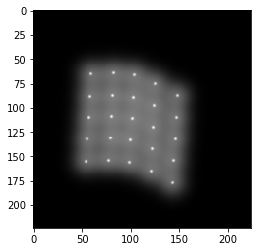

In [8]:
plt.imshow(X[:,:,0], cmap="gray")

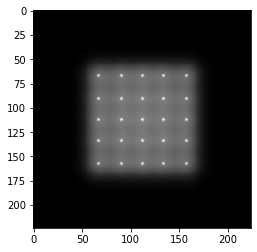

In [9]:
plt.imshow(X[:,:,1], cmap="gray")

In [10]:
moving_json_file = open(path  + '/moving.json')
fixed_json_file = open(path + '/fixed.json')

moving_data = json.load(moving_json_file)
fixed_data = json.load(fixed_json_file)

moving_json_file.close()
fixed_json_file.close()

labels = np.zeros((25,2,2))

for index in range(0,25):
    x = moving_data[str(index)][0]
    y = moving_data[str(index)][1]

    labels[index][0][0] = x
    labels[index][1][0] = y
    
for index in range(0,25):
    x = fixed_data[str(index)][0]
    y = fixed_data[str(index)][1]

    labels[index][0][1] = x
    labels[index][1][1] = y  

# Training Preparation
Prepare the settings for training the model.

In [11]:
X_train = np.array([X])
y_train = np.array([labels])

In [12]:
def eval_displacment(u, x, y):
    u = kb.gather(u, y)
    u = kb.transpose(u)
    u = kb.gather(u, x)
    u = kb.flatten(u)
    indices = [val * 25 + val for val in range(0,25)]
    u = kb.gather(u, indices)
    
    return u

def custom_loss(labels, prediction):
    # BATCH_SIZE = 1
    
    #print(prediction.shape) # batch_sizex112x112x2 (bs, x, y, ux-uy)
    #print(labels.shape) # batch_sizex25x2x2 (bs, coord, x-y, mov-fix)
    
    ux = prediction[0,:,:,0]
    uy = prediction[0,:,:,1]
    
    x_mov = labels[0,:,0,0]
    y_mov = labels[0,:,1,0]
    x_mov_int = kb.cast(x_mov, "int32")
    y_mov_int = kb.cast(y_mov, "int32")
    
    x_fix = labels[0,:,0,1]
    y_fix = labels[0,:,1,1]
    x_fix_int = kb.cast(x_fix, "int32")
    y_fix_int = kb.cast(y_fix, "int32")    
    
    ux_mov = eval_displacment(ux, x_mov_int, y_mov_int)
    uy_mov = eval_displacment(uy, x_mov_int, y_mov_int)
    
    x_squared = kb.square(x_mov + ux_mov - x_fix) # elementwise
    y_squared = kb.square(y_mov + uy_mov - y_fix) 
    
    euclidean_distance = kb.sqrt(x_squared + y_squared)
    mae = kb.mean(x_squared + y_squared)
    
    #mse = kb.mean(x_squared + y_squared)
    #kb.print_tensor(mse)
    
    return mae

In [13]:
logger = CSVLogger(store_path + "/log")

callbacks = [logger]

model.compile(optimizer='adam', loss = custom_loss)
model.fit(X_train, y_train, validation_data=(X_train, y_train), callbacks=callbacks, batch_size=1, epochs=100)

Epoch 1/100
1/1 [==============================] - 1s 754ms/step - loss: 149.1541 - val_loss: 1151.2634
Epoch 2/100
1/1 [==============================] - 0s 156ms/step - loss: 60.2865 - val_loss: 1290.9968
Epoch 3/100
1/1 [==============================] - 0s 157ms/step - loss: 36.8026 - val_loss: 5033.1895
Epoch 4/100
1/1 [==============================] - 0s 158ms/step - loss: 17.1948 - val_loss: 12633.3896
Epoch 5/100
1/1 [==============================] - 0s 161ms/step - loss: 4.7375 - val_loss: 23145.0957
Epoch 6/100
1/1 [==============================] - 0s 155ms/step - loss: 1.5676 - val_loss: 39162.3008
Epoch 7/100
1/1 [==============================] - 0s 155ms/step - loss: 1.3803 - val_loss: 61377.8281
Epoch 8/100
1/1 [==============================] - 0s 166ms/step - loss: 1.1695 - val_loss: 89023.4219
Epoch 9/100
1/1 [==============================] - 0s 161ms/step - loss: 1.6084 - val_loss: 100639.9766
Epoch 10/100
1/1 [==============================] - 0s 156ms/step - lo

1/1 [==============================] - 0s 155ms/step - loss: 2.6626e-04 - val_loss: 90.9239
Epoch 81/100
1/1 [==============================] - 0s 157ms/step - loss: 2.9598e-04 - val_loss: 85.5194
Epoch 82/100
1/1 [==============================] - 0s 155ms/step - loss: 2.0029e-04 - val_loss: 80.8205
Epoch 83/100
1/1 [==============================] - 0s 154ms/step - loss: 3.2085e-04 - val_loss: 76.7141
Epoch 84/100
1/1 [==============================] - 0s 153ms/step - loss: 1.0271e-04 - val_loss: 73.0366
Epoch 85/100
1/1 [==============================] - 0s 155ms/step - loss: 2.4009e-04 - val_loss: 69.4356
Epoch 86/100
1/1 [==============================] - 0s 160ms/step - loss: 1.1276e-04 - val_loss: 65.9384
Epoch 87/100
1/1 [==============================] - 0s 157ms/step - loss: 2.1294e-04 - val_loss: 62.6577
Epoch 88/100
1/1 [==============================] - 0s 213ms/step - loss: 1.0284e-04 - val_loss: 59.5883
Epoch 89/100
1/1 [==============================] - 0s 182ms/step - 

In [14]:
model.save_weights(store_path + "/weights.hdf5")

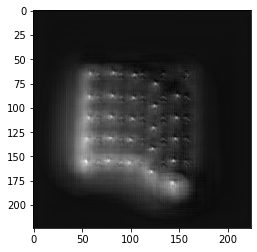

In [15]:
y_pred = model.predict(X_train)

u_x = y_pred[0,:,:,0]
u_y = y_pred[0,:,:,1]

plt.imshow(y_pred[0,:,:,0], cmap="gray")

plt.imsave(store_path + "/u_x.png", u_x, cmap="gray")
plt.imsave(store_path + "/u_y.png", u_y, cmap="gray")

u_x.dump(store_path + "/u_x")
u_y.dump(store_path + "/u_y")

In [16]:
def plot_cube(img, x, y, val):
    
    img[y][x] = val
    img[y][x-1] = val
    img[y][x+1] = val
    img[y-1][x] = val
    img[y-1][x-1] = val
    img[y-1][x+1] = val
    img[y+1][x] = val
    img[y+1][x-1] = val
    img[y+1][x+1] = val  

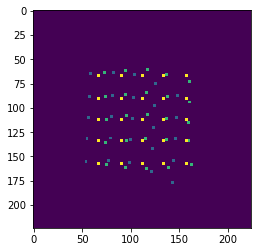

In [17]:
warp = np.zeros((width, height))

for index in range(0,25):
    x = moving_data[str(index)][0]
    y = moving_data[str(index)][1]
    
    plot_cube(warp, x, y, 1) #blue
    
    ux_field = y_pred[0,:,:,0]
    uy_field = y_pred[0,:,:,1]
    
    ux = ux_field[y][x]
    uy = uy_field[y][x]
    
    x = int(round(x + ux))
    y = int(round(y + uy))
            
    plot_cube(warp, x, y, 2) #green    
    
    x = fixed_data[str(index)][0]
    y = fixed_data[str(index)][1]
    
    plot_cube(warp, x, y, 3) #yellow    
    
plt.imshow(warp)
plt.imsave(store_path + "/warp.png", warp)